## Homework 9 for Computational Economics

**{Name, Email, N-Number}**: Arnav Sood, asood@nyu.edu, N11193569

> **Exercise 6:** Write a function that solves the linear quadratic asset pricing model, as stated in lecture, based on iteration

> Define a `LQPrimitives` type to hold the data we require. The type has a hidden `convergenceFlag` field, which we fill with true if the matrices supplied are stable and false otherwise, so that we can immediately determine whether these primitives lead to a unique solution.

> The type also has an inner constructor, to validate data.


In [1]:
type LQPrimitives
        A::Matrix
        C::Matrix
        D::Matrix
        beta::Real
        convergenceFlag::Bool

# Write an inner constructor, which checks for matrix dimensions, the bounds of the discount factor, and warns against unstable primitives.

    function LQPrimitives(A,C,D,beta)

        convergenceFlag = true

        if ~(beta > 0 && beta < 1)
        throw(ArgumentError("Beta is not within the required range"))
        end

        if ~(size(A) == size(D) && size(A) == size(C))
        throw(ArgumentError("The matrices you supplied are not of the same dimension."))
        end

        if ~(typeof(det(A)) <: Number && typeof(det(C)) <: Number && typeof(det(D)) <: Number)
        throw(ArgumentError("The matrices you supplied are not all square."))
        end

        if (maximum(abs(eig(A)[1])) >= 1/sqrt(beta))
        convergenceFlag = false
        warn("The primitives supplied do not satisfy the stability condition.")    
        end

        new(A,C,D,beta,convergenceFlag)
    end
    
end

> Test constructor.

In [2]:
using BaseTestNext
const Test = BaseTestNext

@test typeof(LQPrimitives([1 2 ; 1 2], [1 2 ; 1 2], [1 2 ; 1 2 ],0.5)) <: Any
@test_throws ArgumentError LQPrimitives([1, 2], [ 1 2 ; 1 2 ], [ 1 2 ; 1 2],0.5)
@test_throws ArgumentError LQPrimitives([1 2 ; 1 2], [1 2 3 ; 1 2 3 ; 1 2 3], [1 2 ; 1 2],0.5)


Test Passed
  Expression: LQPrimitives([1 2;1 2],[1 2 3;1 2 3;1 2 3],[1 2;1 2],0.5)
      Thrown: ArgumentError

> Write a function to accept a primitives object and iteratively solve the Lyapunov equation.

In [3]:
function solveLyapunov(primitives::LQPrimitives,iterationBound::Integer=500,toleranceBound::Float64 = 1e-4)

A = primitives.A
C = primitives.C
D = primitives.D
beta = primitives.beta
convergenceFlag = primitives.convergenceFlag
numStates = size(A)[1]
numDims = numStates
iterationCount = 0
normDiff = Inf
P = zeros(numStates,numDims) + 1//numStates

if convergenceFlag == false
print("The stability condition does not hold. Therefore, no unique pricing function exists.")
return
end

function update(P::Matrix)
        return beta*A'*(D+P)*A
end

function computeDelta(P::Matrix)
        return beta/(1-beta)*trace(C'*(D+P)*C)
end

while iterationCount <= iterationBound
        normDiff = norm(P-update(P))
        if normDiff < toleranceBound
                return P, computeDelta(P)
        end
        P = update(P)
        iterationCount +=1
end

warn("Maximum Iteration Count Exceeded")
    return P, computeDelta(P)[1]
end    

solveLyapunov (generic function with 3 methods)

> Write a function to compute a price, given primitives and a state.

In [4]:
function solveLyapunov(primitives::LQPrimitives,states::Vector,iterationBound::Integer=500,toleranceBound::Float64=1e-4)
P,delta = solveLyapunov(primitives,iterationBound,toleranceBound)

# Make sure states are a column vector
if size(states)[1] == 1
        states = states'
end

price = states'*P*states + delta
    return price[1]
    
end

solveLyapunov (generic function with 6 methods)

> Test for exercise values.

In [5]:
# Test
examplePrimitives = LQPrimitives([0.8 -0.1; -0.1 0.8], [1.0 0; 0 1], [1.0 0; 0 1], 0.9)
results = solveLyapunov(examplePrimitives)
println(results)

# Test price
println(solveLyapunov(examplePrimitives,[1.0, 2.0]))

(
[1.7393322844035017 -0.9504235187402417
 -0.9504235187402417 1.7393322844035017],

49.30798111926304)
54.

> Generate contour plot.

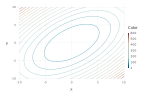

20294846631958


In [6]:
using Gadfly
xrange = collect(linspace(-10.0,10.0,100))
yrange = collect(linspace(-10.0,10.0,100))
plot(z = (x,y) -> solveLyapunov(examplePrimitives,[x,y]),x=xrange,y=yrange,Geom.contour)